In [56]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import numpy as np
import pandas as pd
from matplotlib import animation
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from IPython.display import HTML
from collections import defaultdict

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from minisom import MiniSom
from sklearn.metrics import davies_bouldin_score, normalized_mutual_info_score, homogeneity_completeness_v_measure

from typing import List

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Load the dataset (LaBSE) and unify them

# Load all data
train_data = pd.read_csv("data/training_labse.csv")
test_data = pd.read_csv("data/test_labse.csv")
validation_data = pd.read_csv("data/validation_labse.csv")

# Separate X's and y's from each other
FEATURE_COLUMNS = [x for x in train_data if x.startswith("_e")]
LABEL_COLUMN = "label"

X_train = train_data[FEATURE_COLUMNS]
Y_train = train_data[LABEL_COLUMN]

X_test = test_data[FEATURE_COLUMNS]
Y_test = test_data[LABEL_COLUMN]

X_val = validation_data[FEATURE_COLUMNS]
Y_val = validation_data[LABEL_COLUMN]

# Merge them 
X = pd.concat([X_train, X_test, X_val])
Y = pd.concat([Y_train, Y_test, Y_val])

In [107]:

CLASSES = ["sadness", "joy", "love", "anger", "fear", "surprise", "none"]

# PCA

In [4]:
# Apply PCA since the data is highly dimensional

# Perform pre-processing PCA on the training set
def perform_pca(dataset, target_variance):
    pca = PCA(n_components= target_variance)

    # Need to standardize the data frirst
    standardized = (dataset - dataset.mean(axis=0)) / dataset.std(axis = 0)

    pca.fit(X=standardized)
    dataset_reduced = pca.fit_transform(X=standardized)

    return pca, dataset_reduced

# K means Clustering

In [4]:
class KmeansResult:
    def __init__(self, k, dbi = 0, nmi = 0, hcv = (0, 0, 0)):
        self.k = k 
        self.dbi = dbi 
        self.nmi = nmi 
        self.homogeneity, self.completeness, self.v_score = hcv


In [5]:
# Apply K means to X_used
def run_search_for_k(dataset, gt, k=20):
    scores : List[KmeansResult] = []
    for n_clusters in range(2,k):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto").fit(dataset)
        labels = kmeans.labels_

        scores.append(
            KmeansResult(
                k=n_clusters,
                dbi= davies_bouldin_score(dataset, labels),
                nmi= normalized_mutual_info_score(gt, labels),
                hcv =homogeneity_completeness_v_measure(gt, labels)
            )
        )

    return scores

In [6]:
MAX_K = 20
MAX_C = X.shape[1]
true_scores = [[KmeansResult(k) for k in range(2, MAX_K)]]

for components in range(2, MAX_C):
    pca, X_reduced = perform_pca(X, components)
    print(f"{pca.n_components_} components for training")
    
    scores = run_search_for_k(X_reduced, Y, MAX_K)
    true_scores.append(scores)

2 components for training
3 components for training
4 components for training
5 components for training
6 components for training
7 components for training
8 components for training
9 components for training


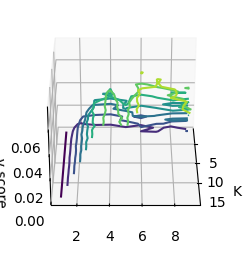

In [17]:
k_indices = np.array([k for k in range(2, MAX_K)])
pca_indices = np.array([i for i in range(1, MAX_C)])

fig = plt.figure()
ax1 = fig.add_subplot(121, projection='3d')

top = np.array([[S.v_score for S in score] for score in true_scores])
bottom = np.zeros_like(top)
width = depth = 1

xx, yy = np.meshgrid(k_indices, pca_indices)
ax1.contour(k_indices, pca_indices, top) 
ax1.set_xlabel("K")
ax1.set_ylabel("pca components")
ax1.set_zlabel("v score")

def animate(frame):
  ax1.view_init(30, frame/4)
  plt.pause(.001)
  return fig

anim = animation.FuncAnimation(fig, animate, frames=200, interval=50)
HTML(anim.to_html5_video())

# Self-Organizing Map

In [51]:
som_y = Y

som_X = X.values

grid_size = (30, 30)

# Create and train the SOM
som = MiniSom(grid_size[0], grid_size[1], som_X.shape[1], sigma=1.5, learning_rate=0.1, random_seed=42, neighborhood_function="gaussian")
som.train(som_X, 1, True, verbose = True, use_epochs=True)

 [ 20000 / 20000 ] 100% - 0:00:00 left 
 quantization error: 0.7148941384191817


In [77]:
som_map = som.labels_map(som_X, Y)
som_map = som.labels_map(som_X, som_y)
# Assign names to each array in the som_map based on the majority class
nearest_names = defaultdict(str)
for x, items in som_map.items():
    if (len(items) != 0):
        nearest_names[x] = items
    else:
        nearest_names[x] = [6]

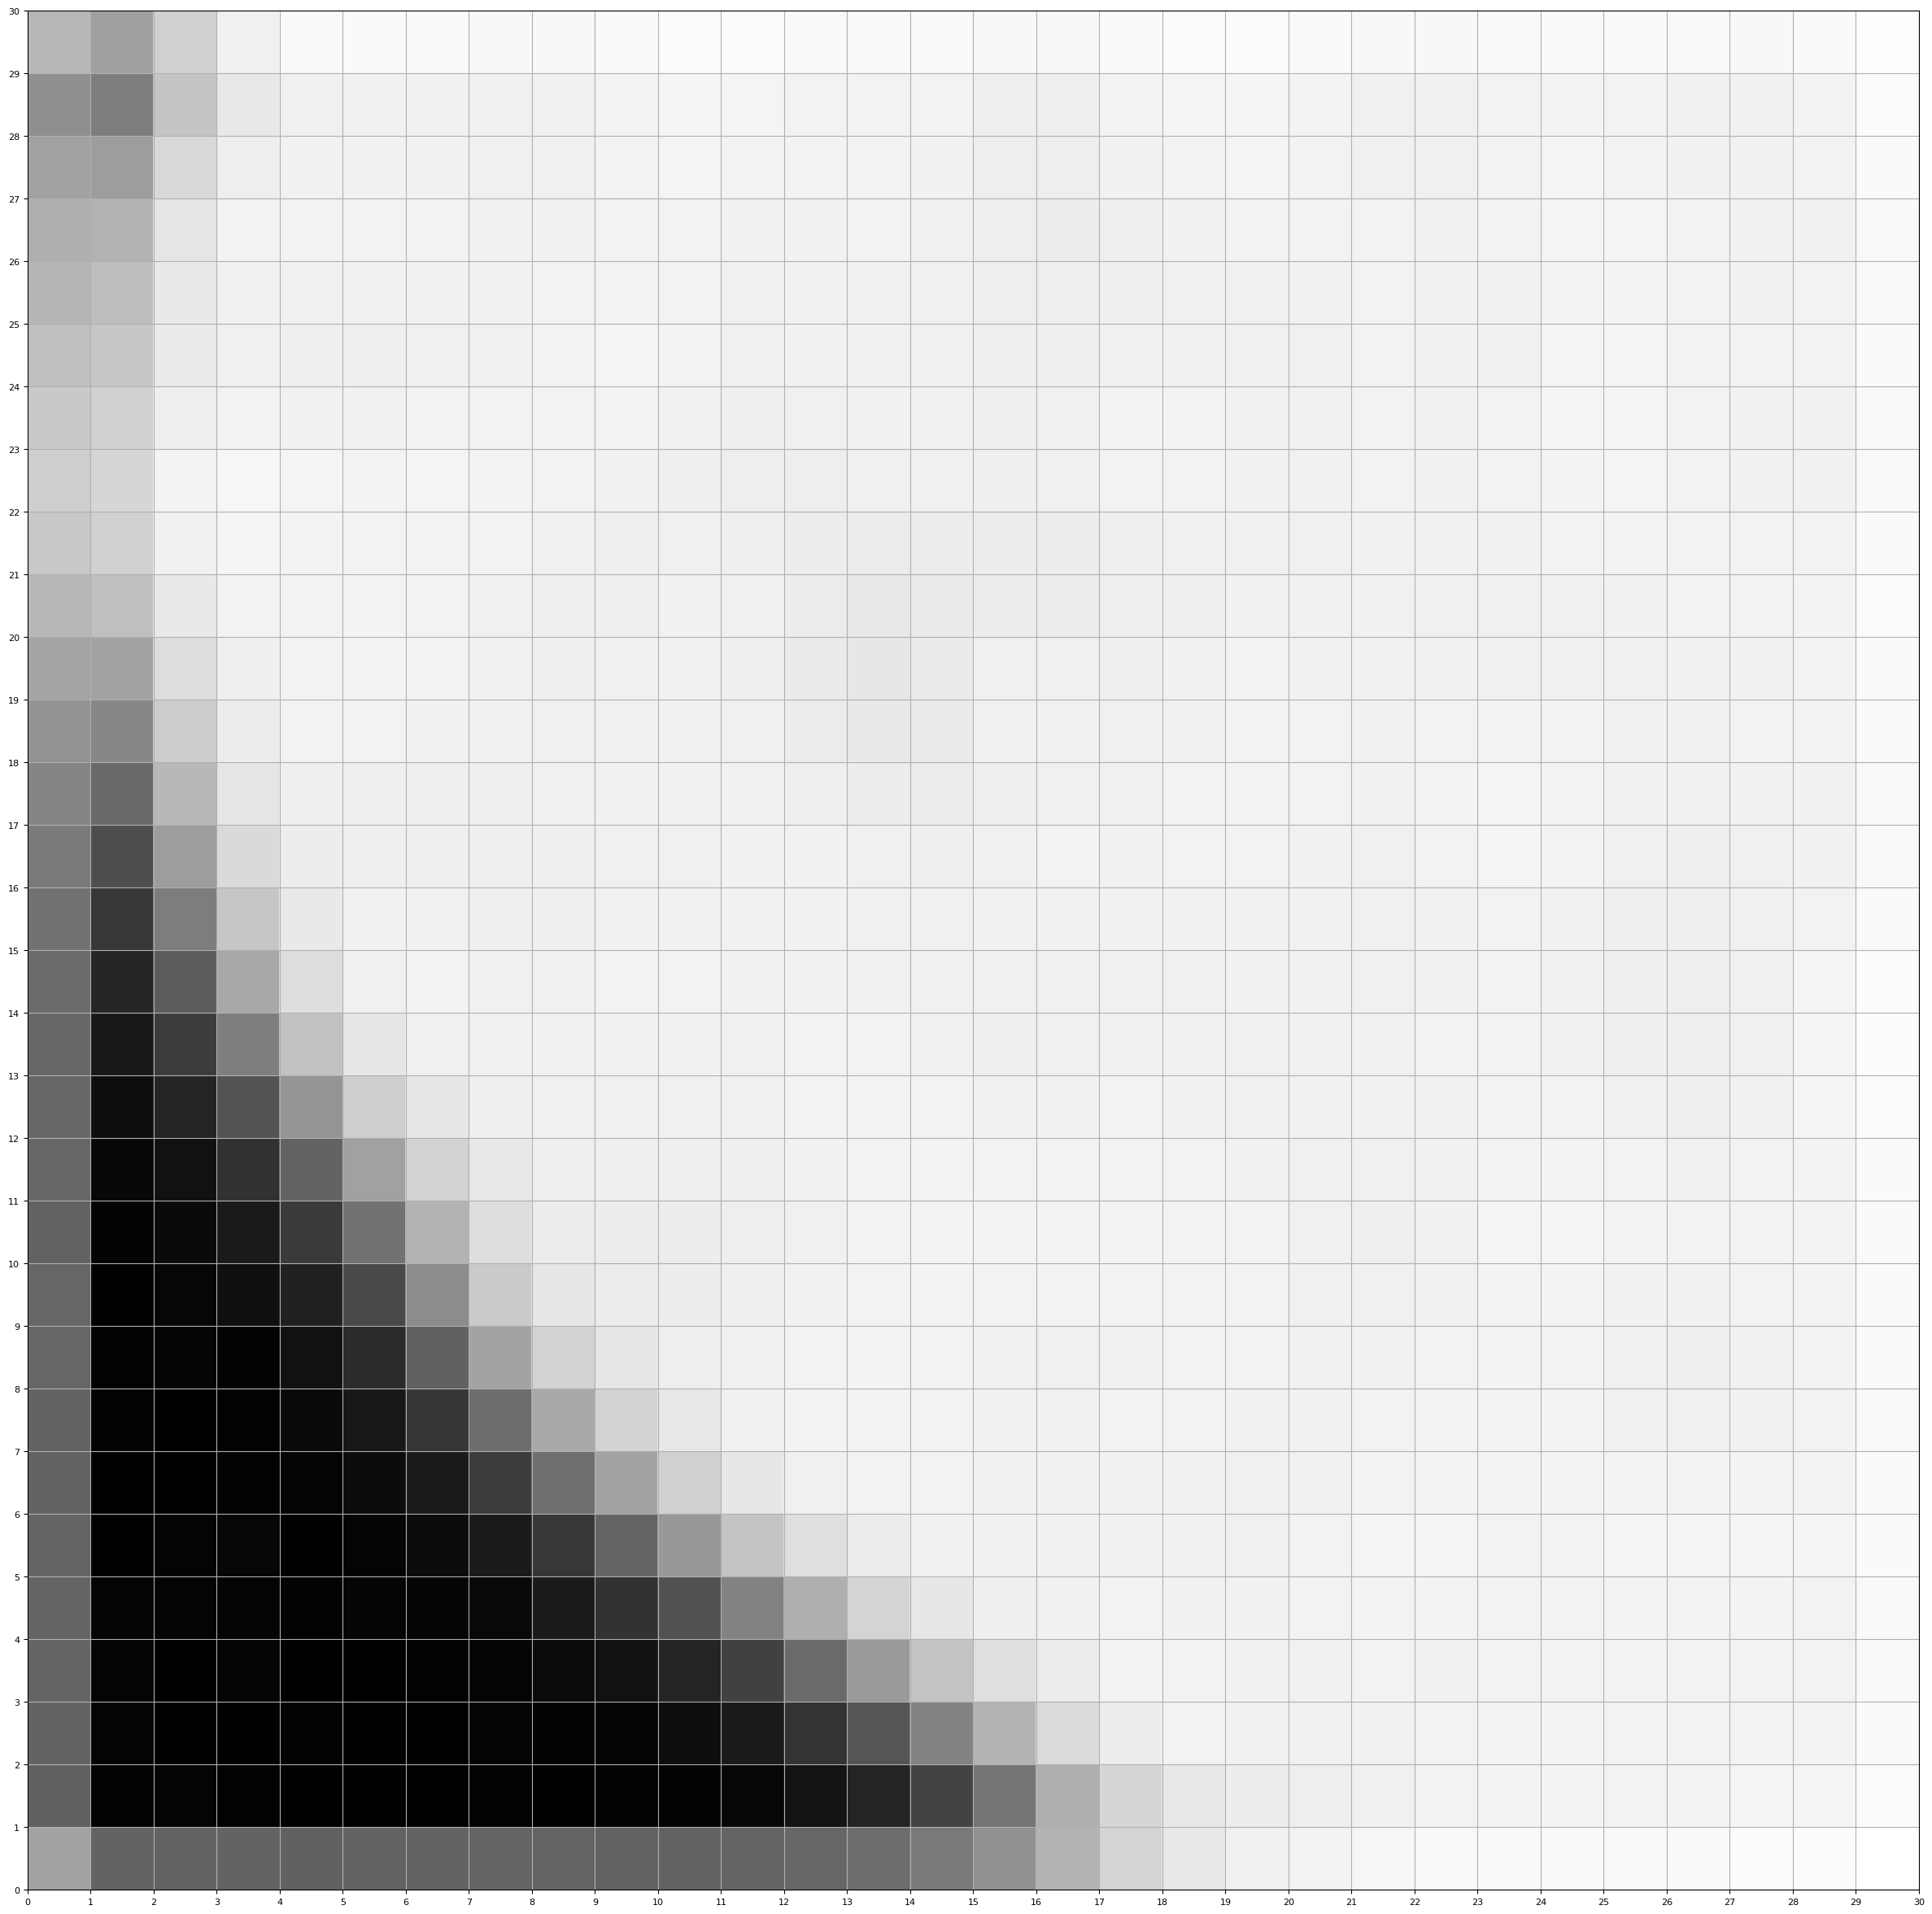

In [78]:
# Visualize the SOM and label based on the name of the majority class
plt.figure(figsize=grid_size)
plt.pcolor(som.distance_map().T, cmap='gray_r')
plt.xticks(np.arange(grid_size[0]+1), fontsize=8)
plt.yticks(np.arange(grid_size[1]+1), fontsize=8)
plt.grid()
plt.show()

In [119]:
entries = {}
for j in range(grid_size[1]):
    for i in range(grid_size[0]):
        cand = nearest_names.get((i, j))
        if cand == None: 
            entries[(i, j)] = [0 for _ in CLASSES]
            entries[(i, j)][-1] = 1
        else:
            counts = [cand[k] for k in range(len(CLASSES))] 
            entries[(i, j)] = counts

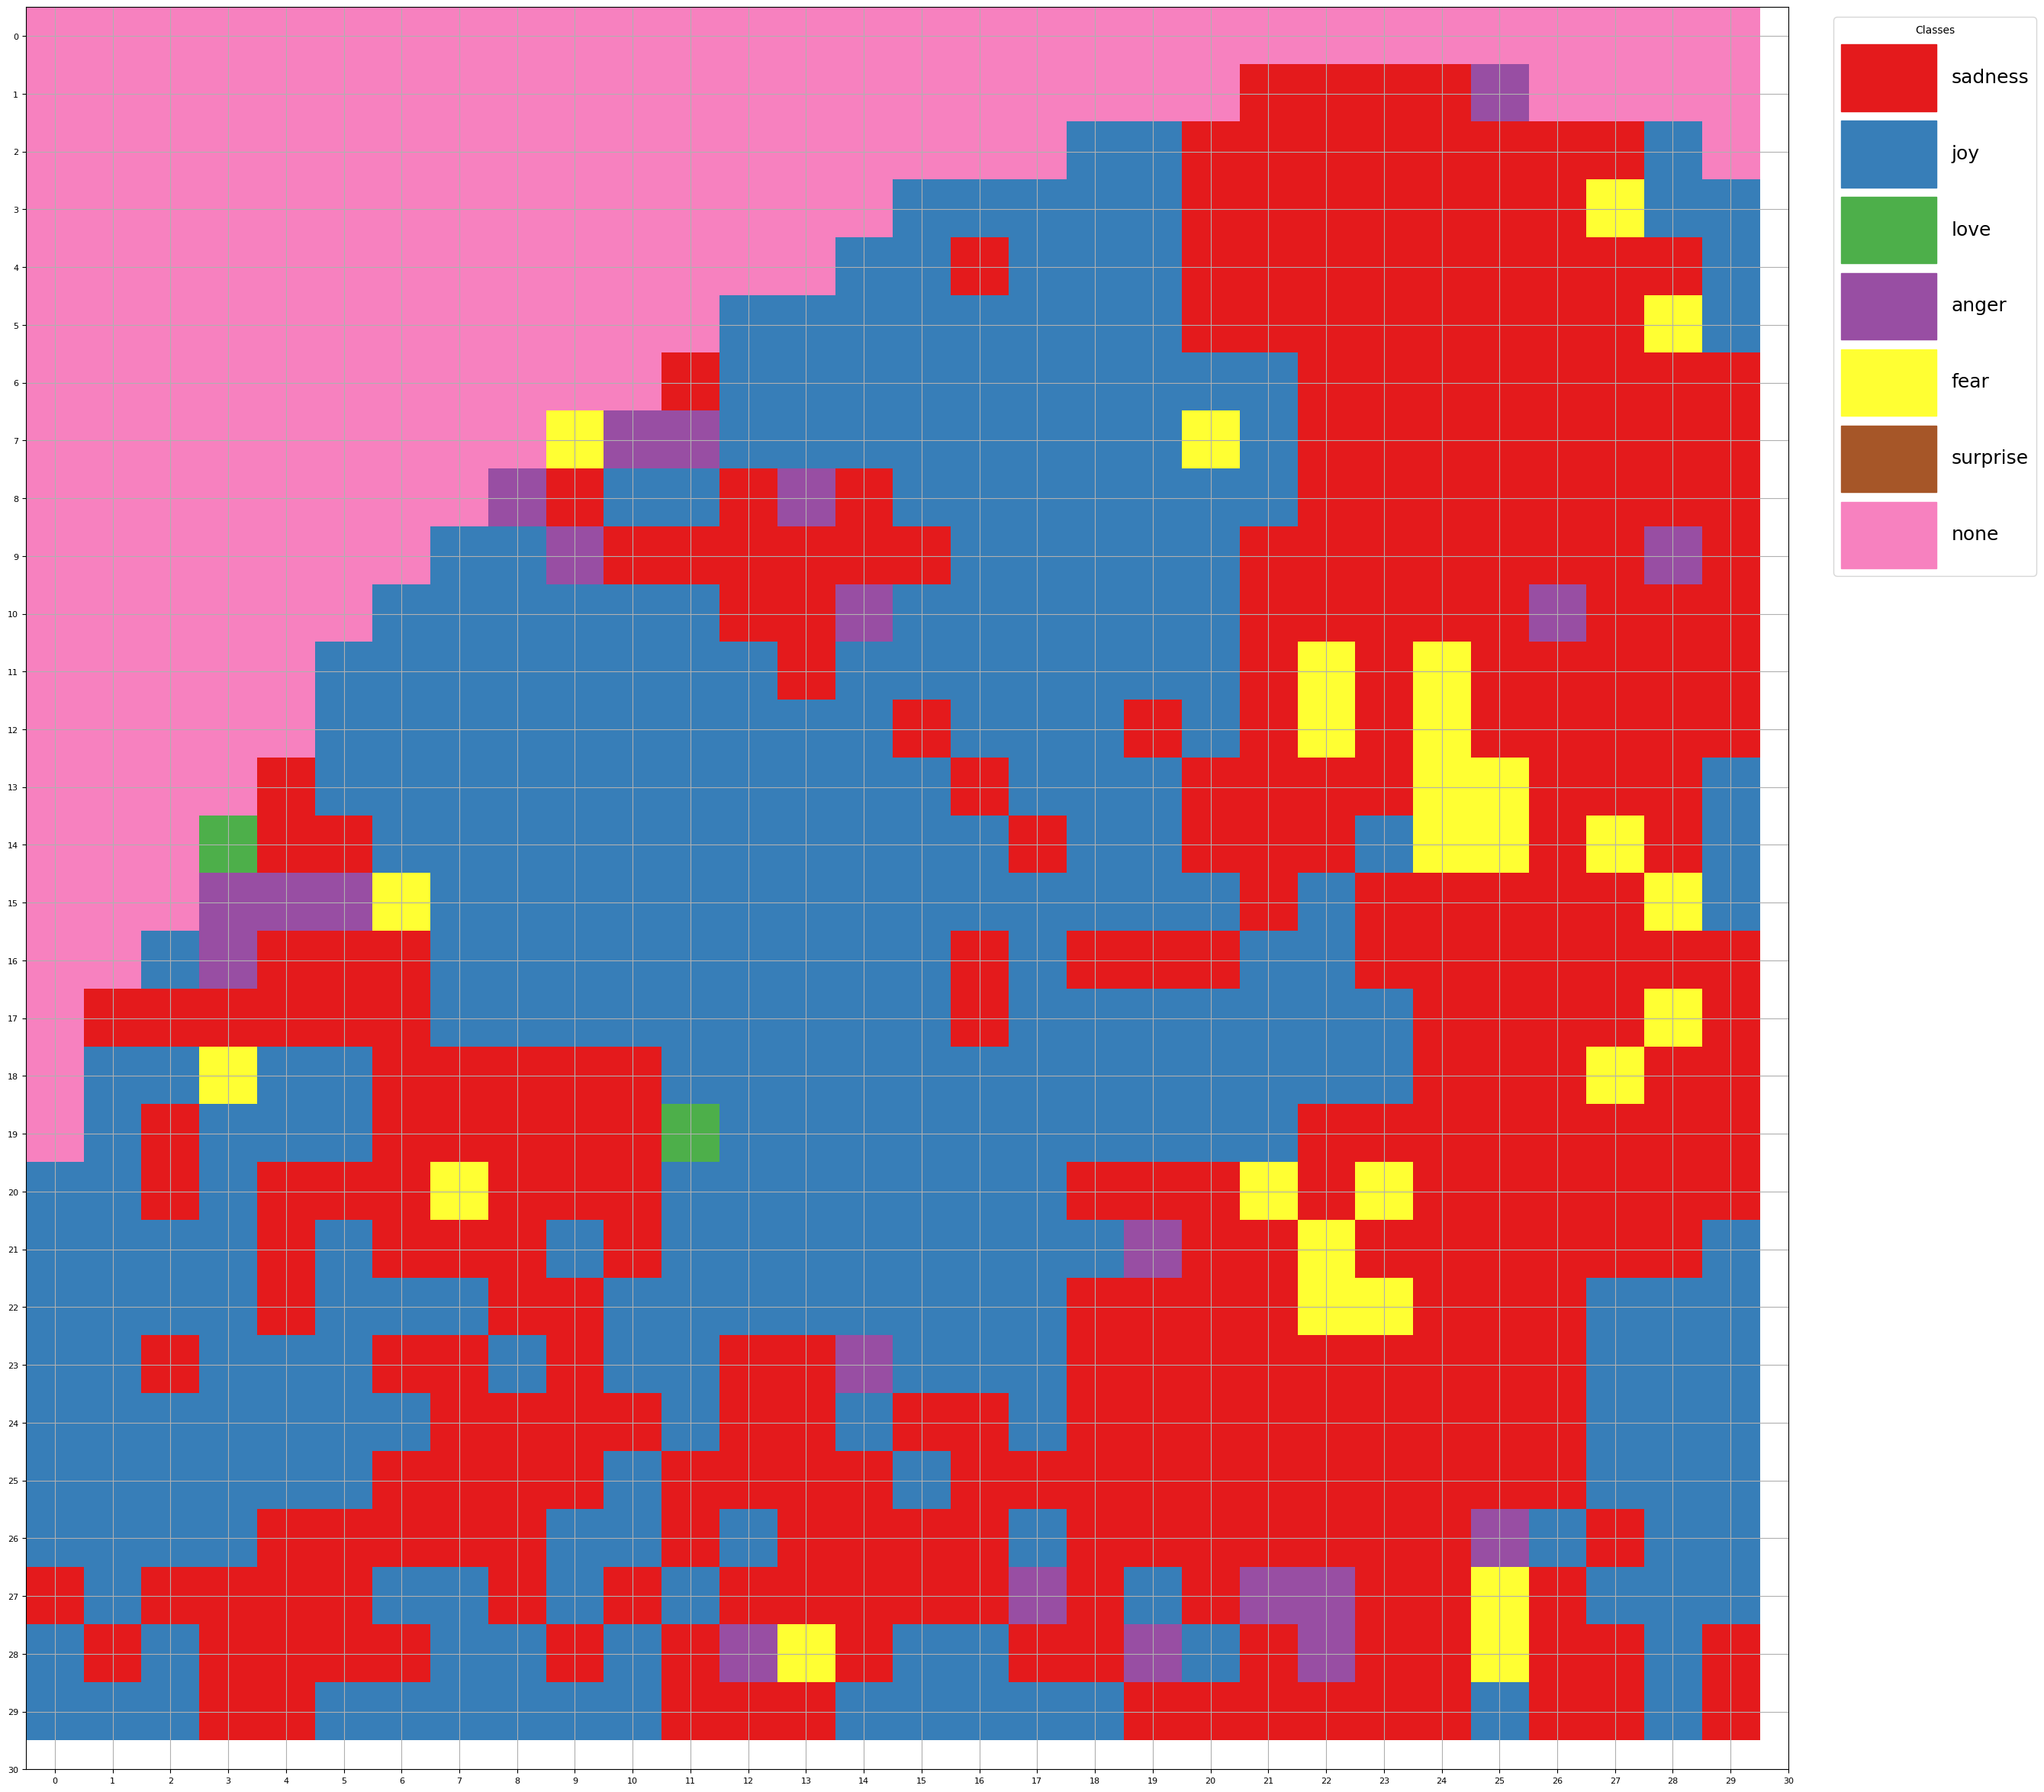

In [109]:
# Visualize the SOM and label based on the name of the majority class
cmap = [cm.Set1(i / len(CLASSES)) for i in range(len(CLASSES))]
        
plt.figure(figsize=grid_size)

grid_colors = [[cmap[np.argmax(entries.get((i, j)))] for j in range(grid_size[1])] for i in range(grid_size[0])]
alphas = som.distance_map().T

plt.imshow(grid_colors, alpha=alphas)
plt.xticks(np.arange(grid_size[0]+1), fontsize=8)
plt.yticks(np.arange(grid_size[1]+1), fontsize=8)
plt.grid()

# Create legend patches for each class
legend_patches = [mpatches.Patch(color=cmap[i], label=CLASSES[i]) for i in range(len(CLASSES))]

# Add the legend to the plot
plt.legend(handles=legend_patches, loc='upper left', title="Classes", handlelength=5, handleheight=5, fontsize = 18, bbox_to_anchor=(1.02, 1))

plt.show()

In [142]:
def get_label_grid(entries, label_idx, maxX, maxY):
    label_grid = np.zeros((maxX,maxY))
    for y in range(maxY):
        for x in range(maxX):
            label_grid[y][x] = entries[(x,y)][label_idx]
    
    return label_grid

In [148]:
# Visualize the SOM of each class
def plot_som_per_class(idx):
    label_grid = get_label_grid(entries, idx, grid_size[0], grid_size[1])
    plt.figure(figsize=grid_size)
    plt.title(CLASSES[idx], fontsize = 64)
    plt.imshow(label_grid, cmap='gray_r', interpolation='none', aspect='auto', extent=[0, grid_size[0], 0, grid_size[1]])
    plt.xticks(np.arange(grid_size[0]+1), fontsize=8)
    plt.yticks(np.arange(grid_size[1]+1), fontsize=8)
    plt.grid()
    plt.show()

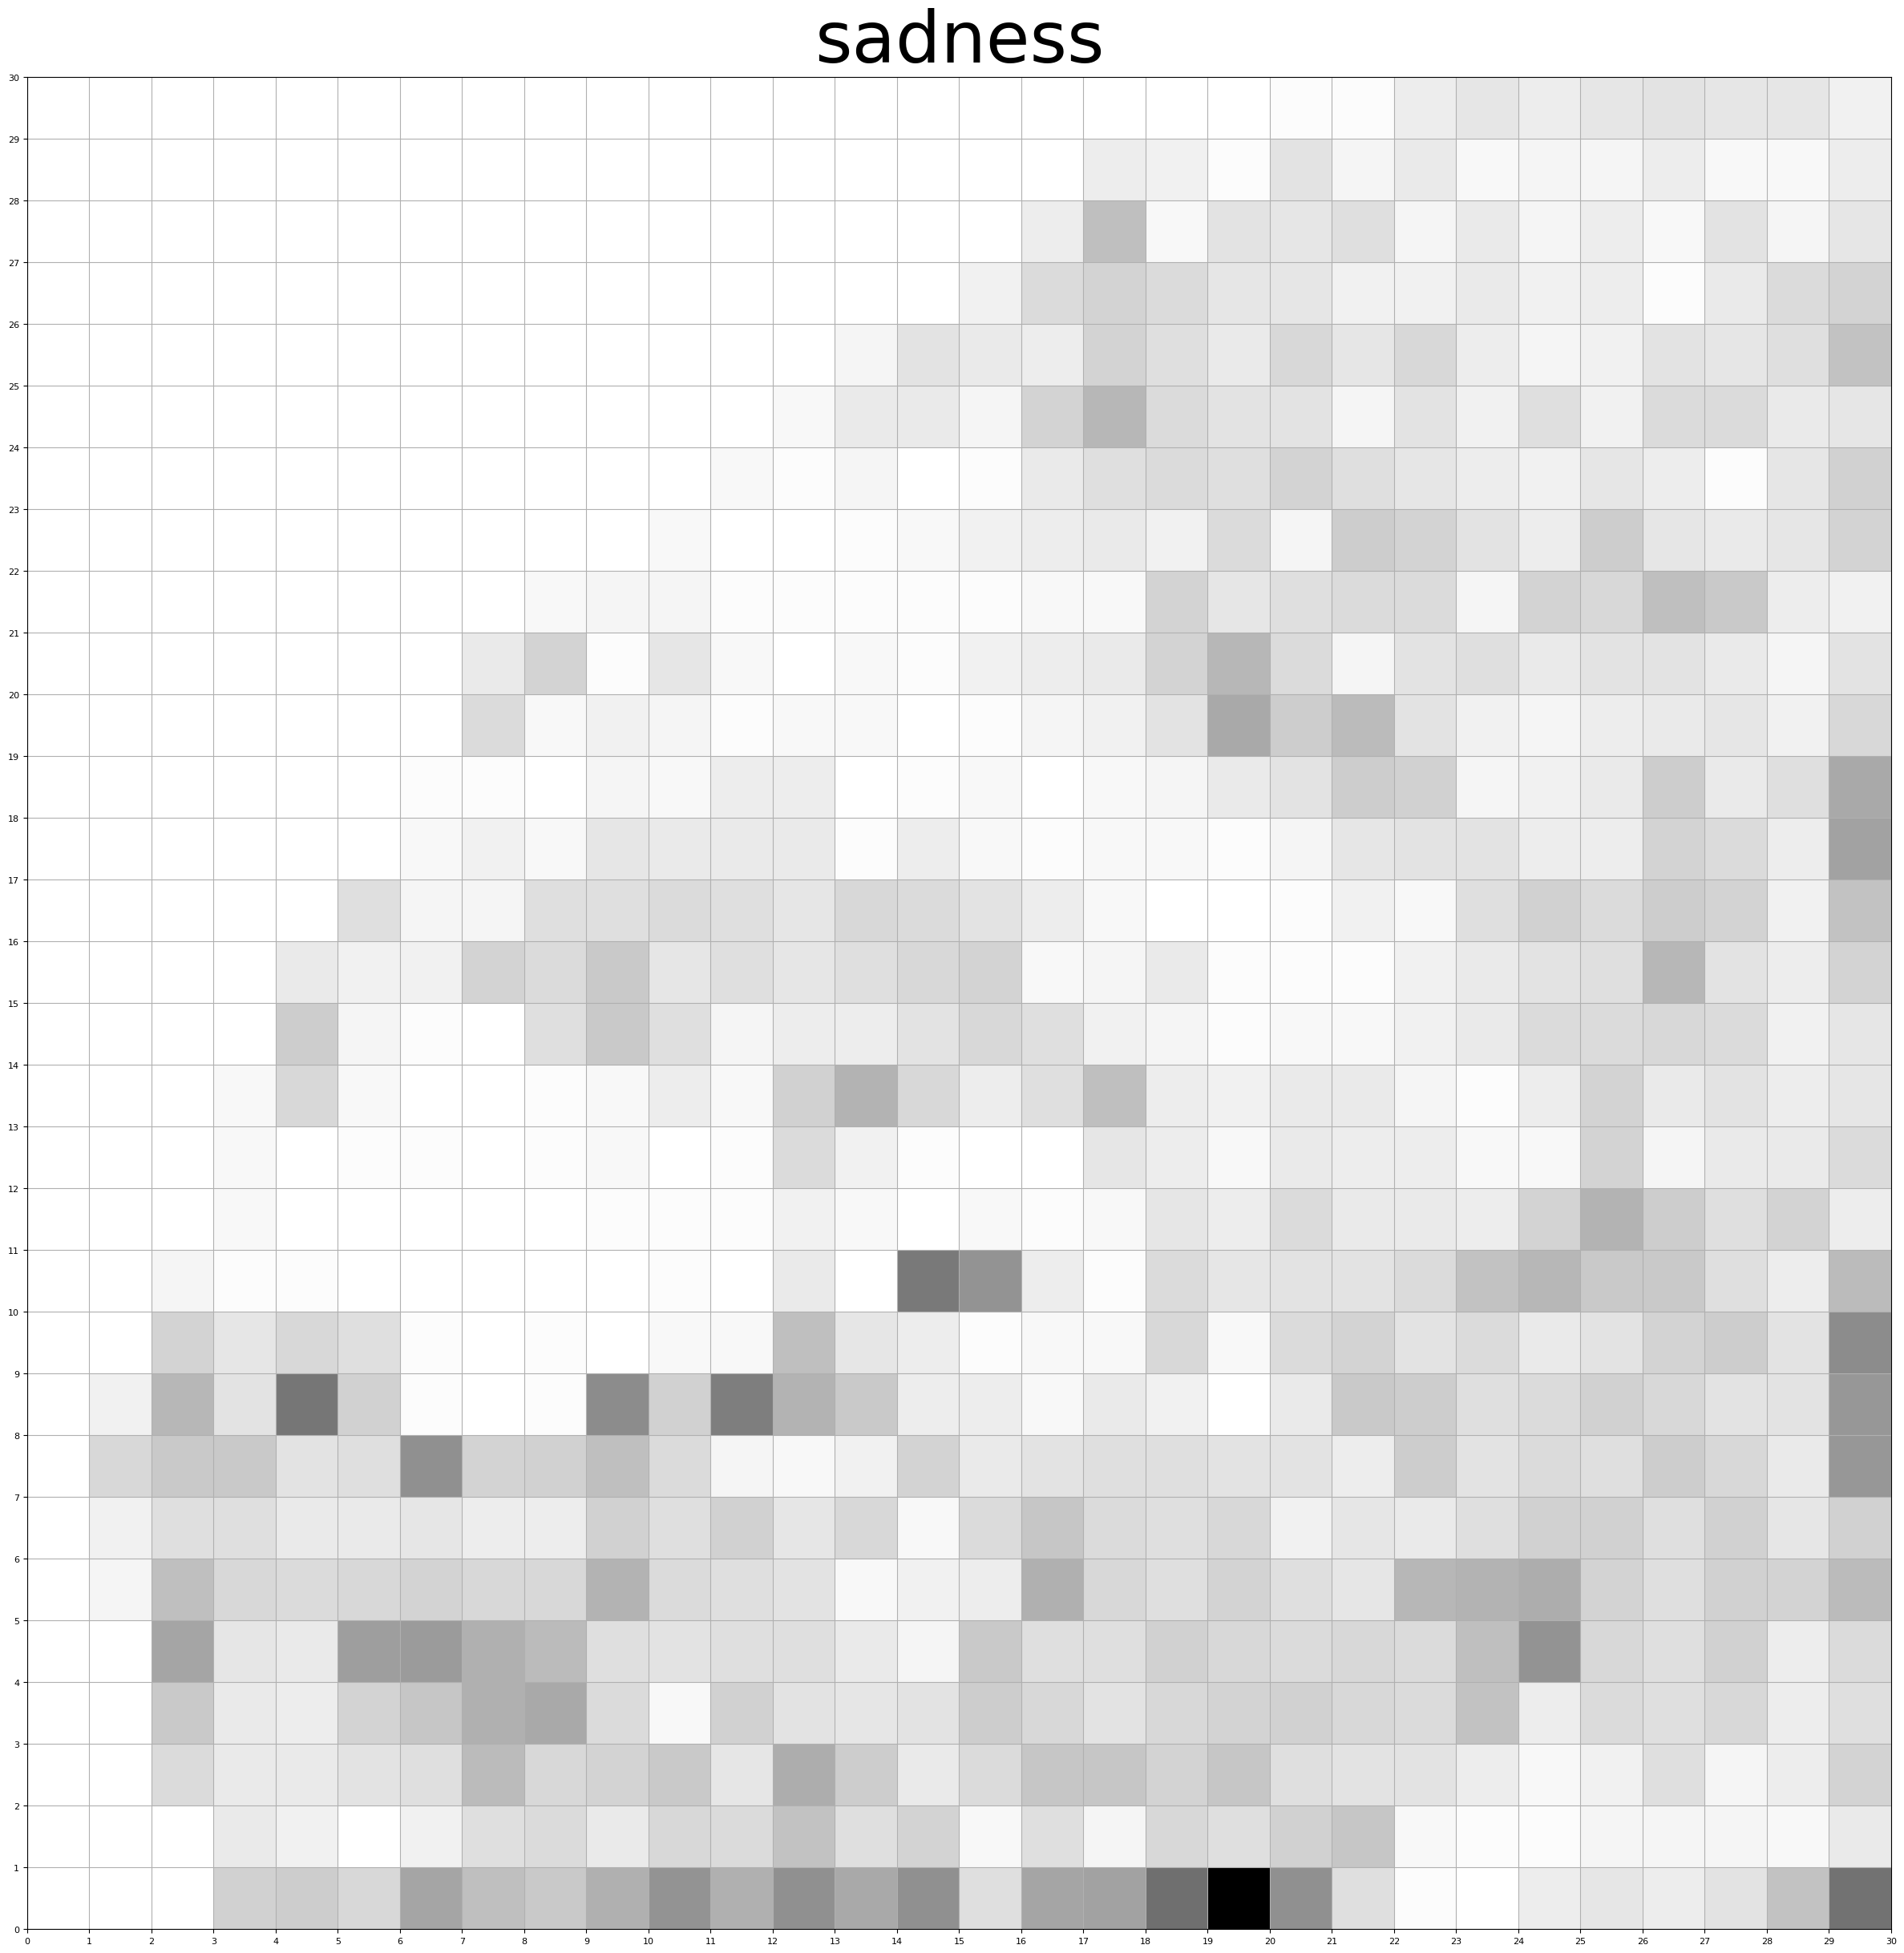

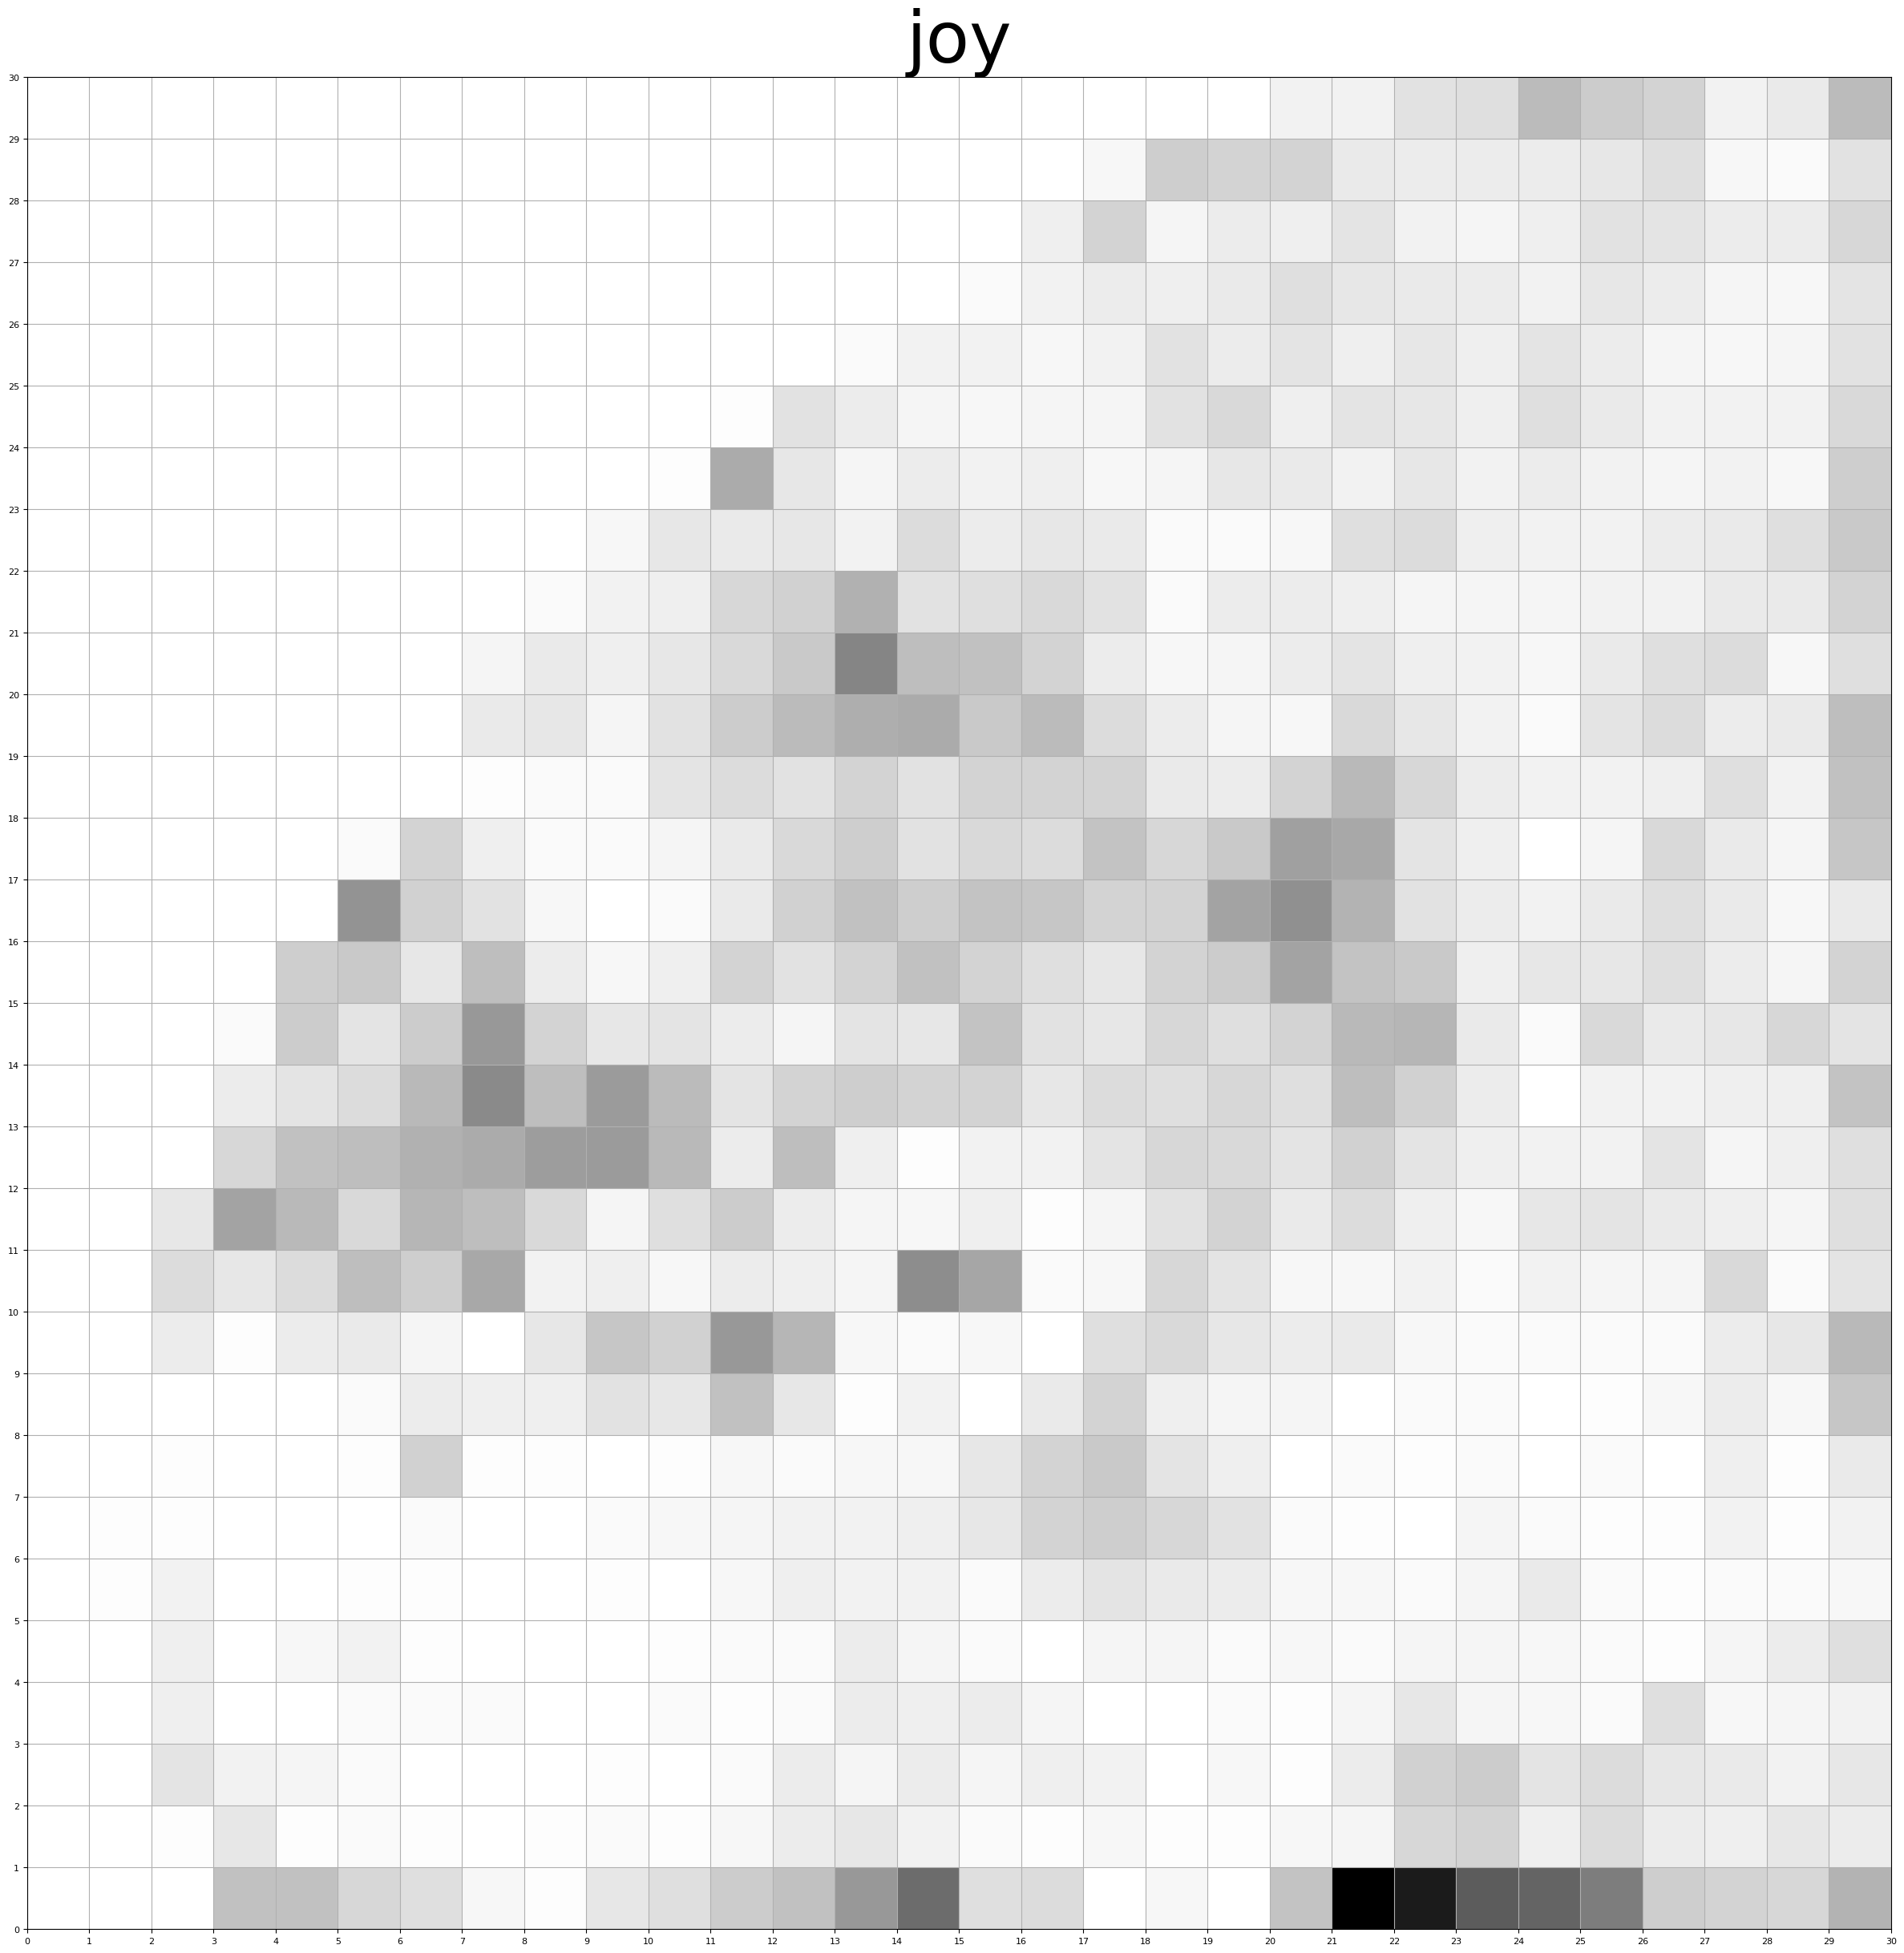

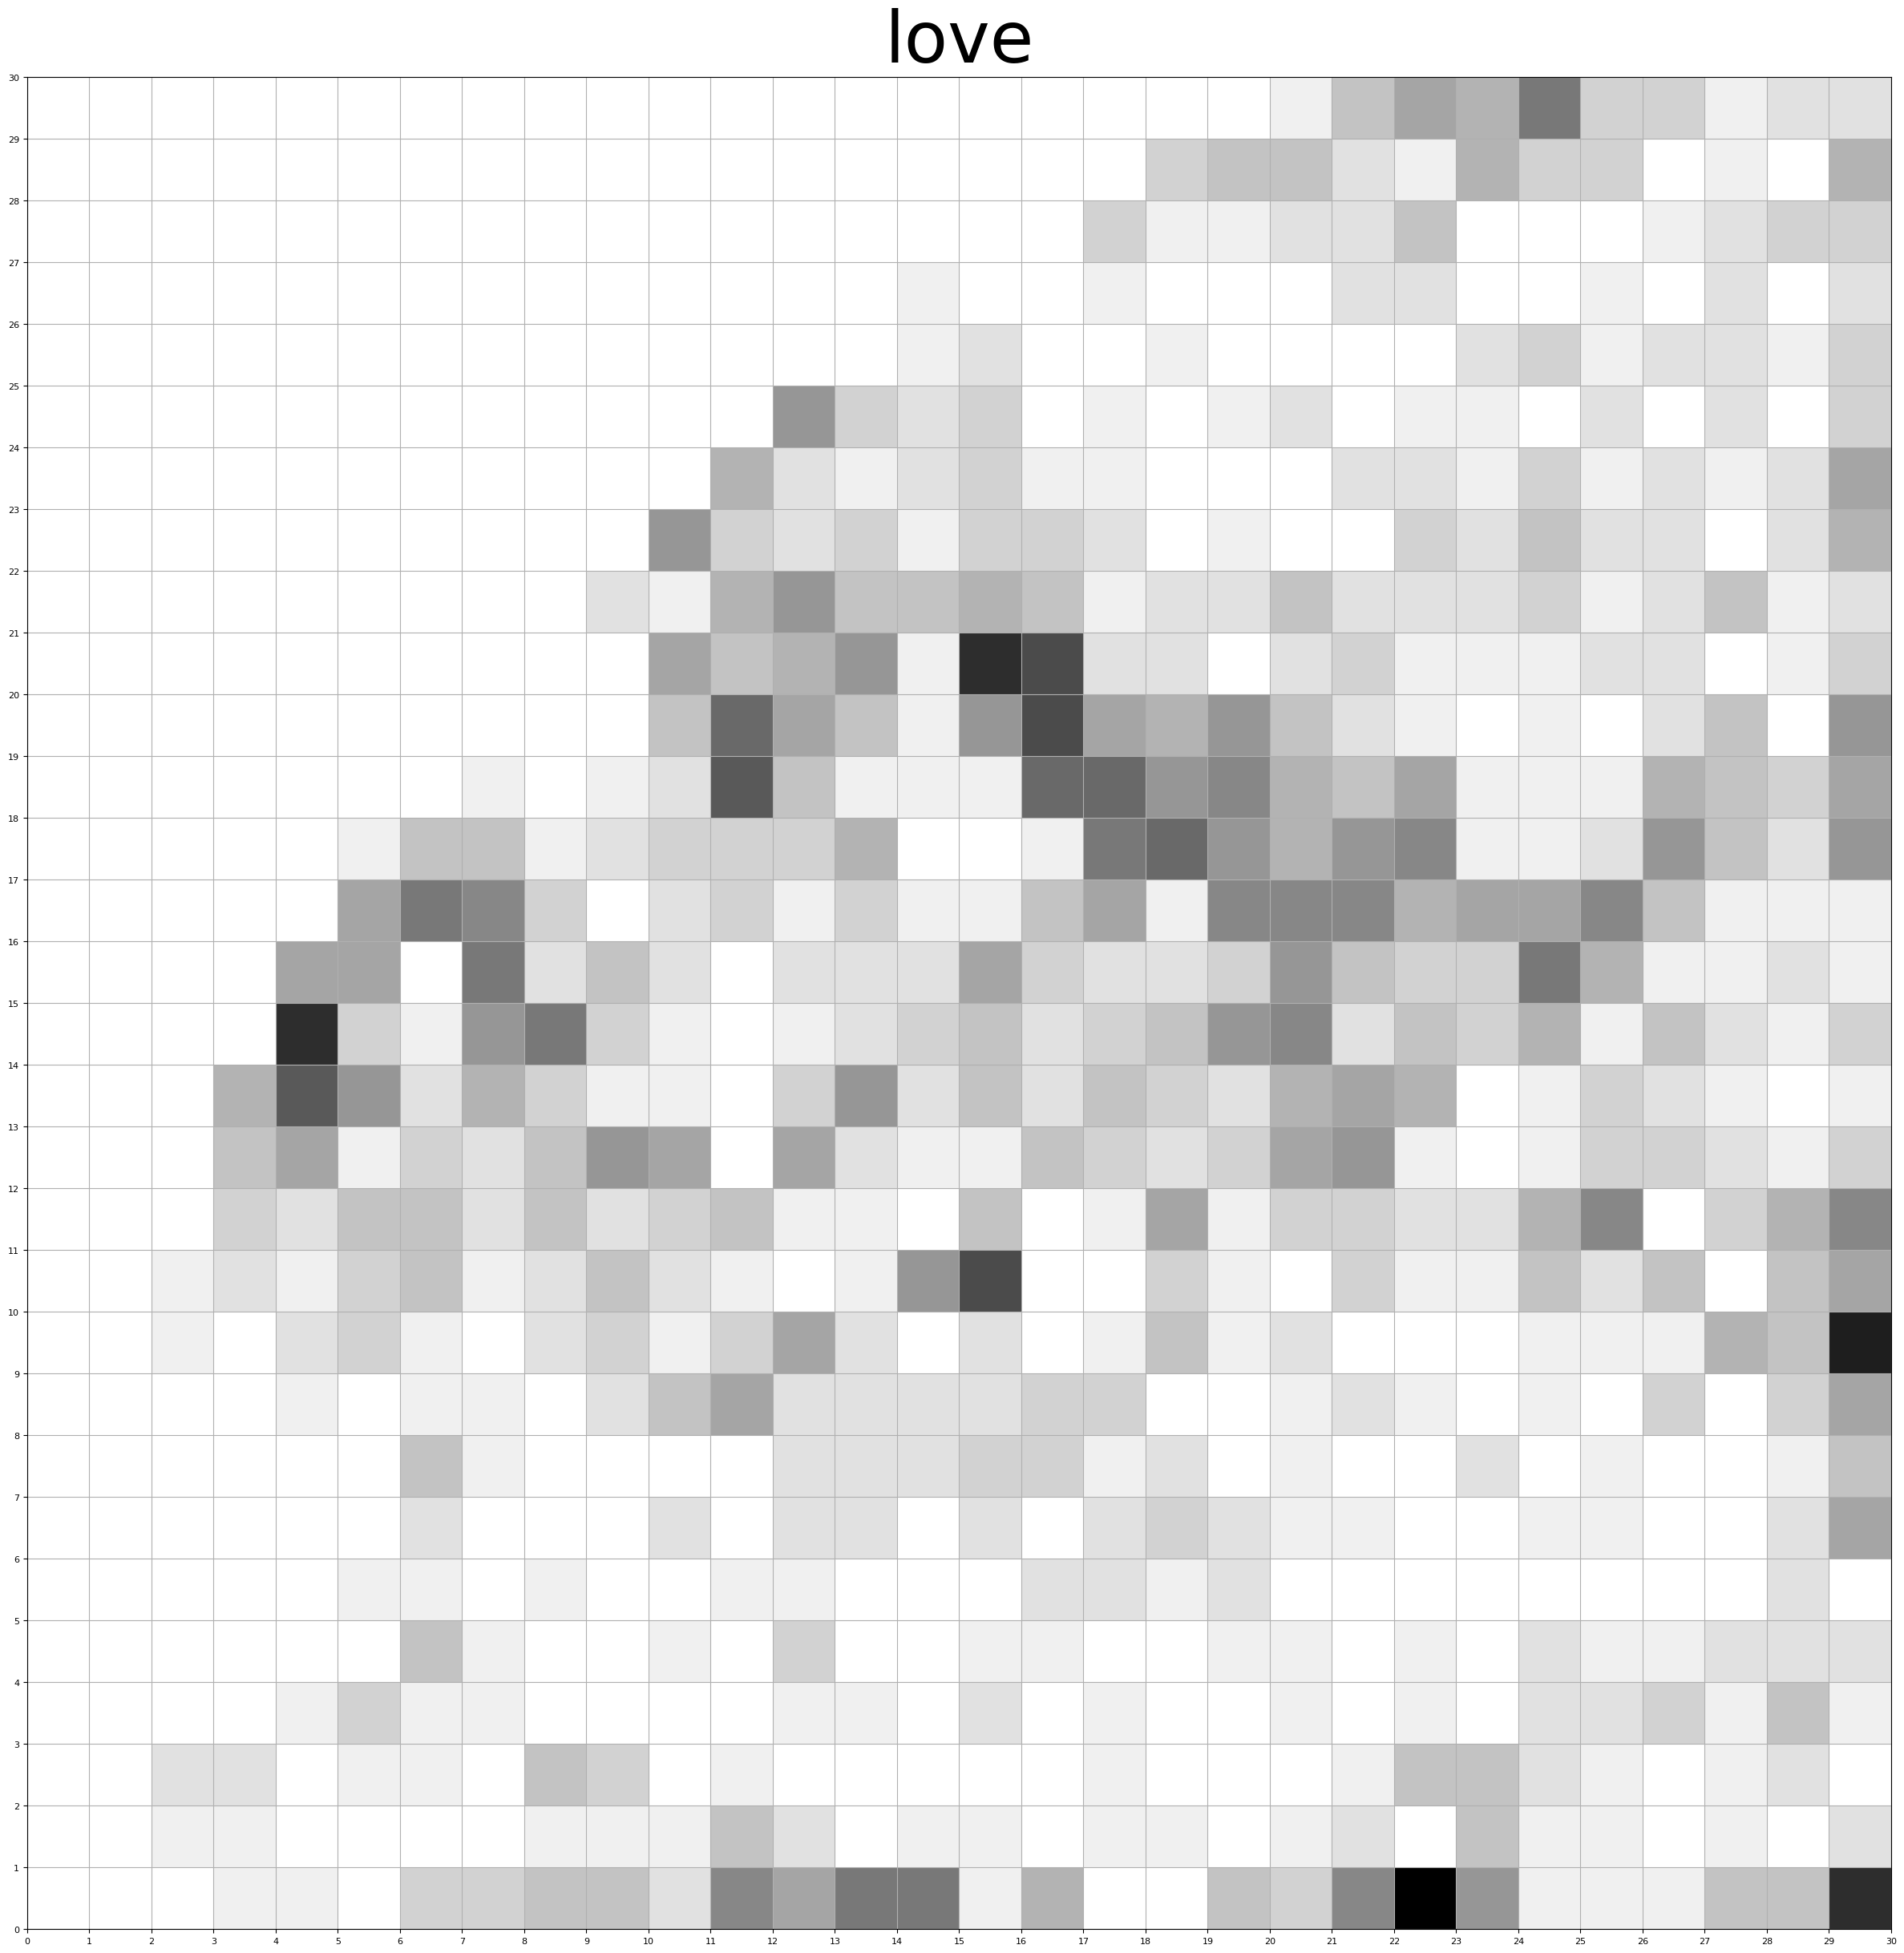

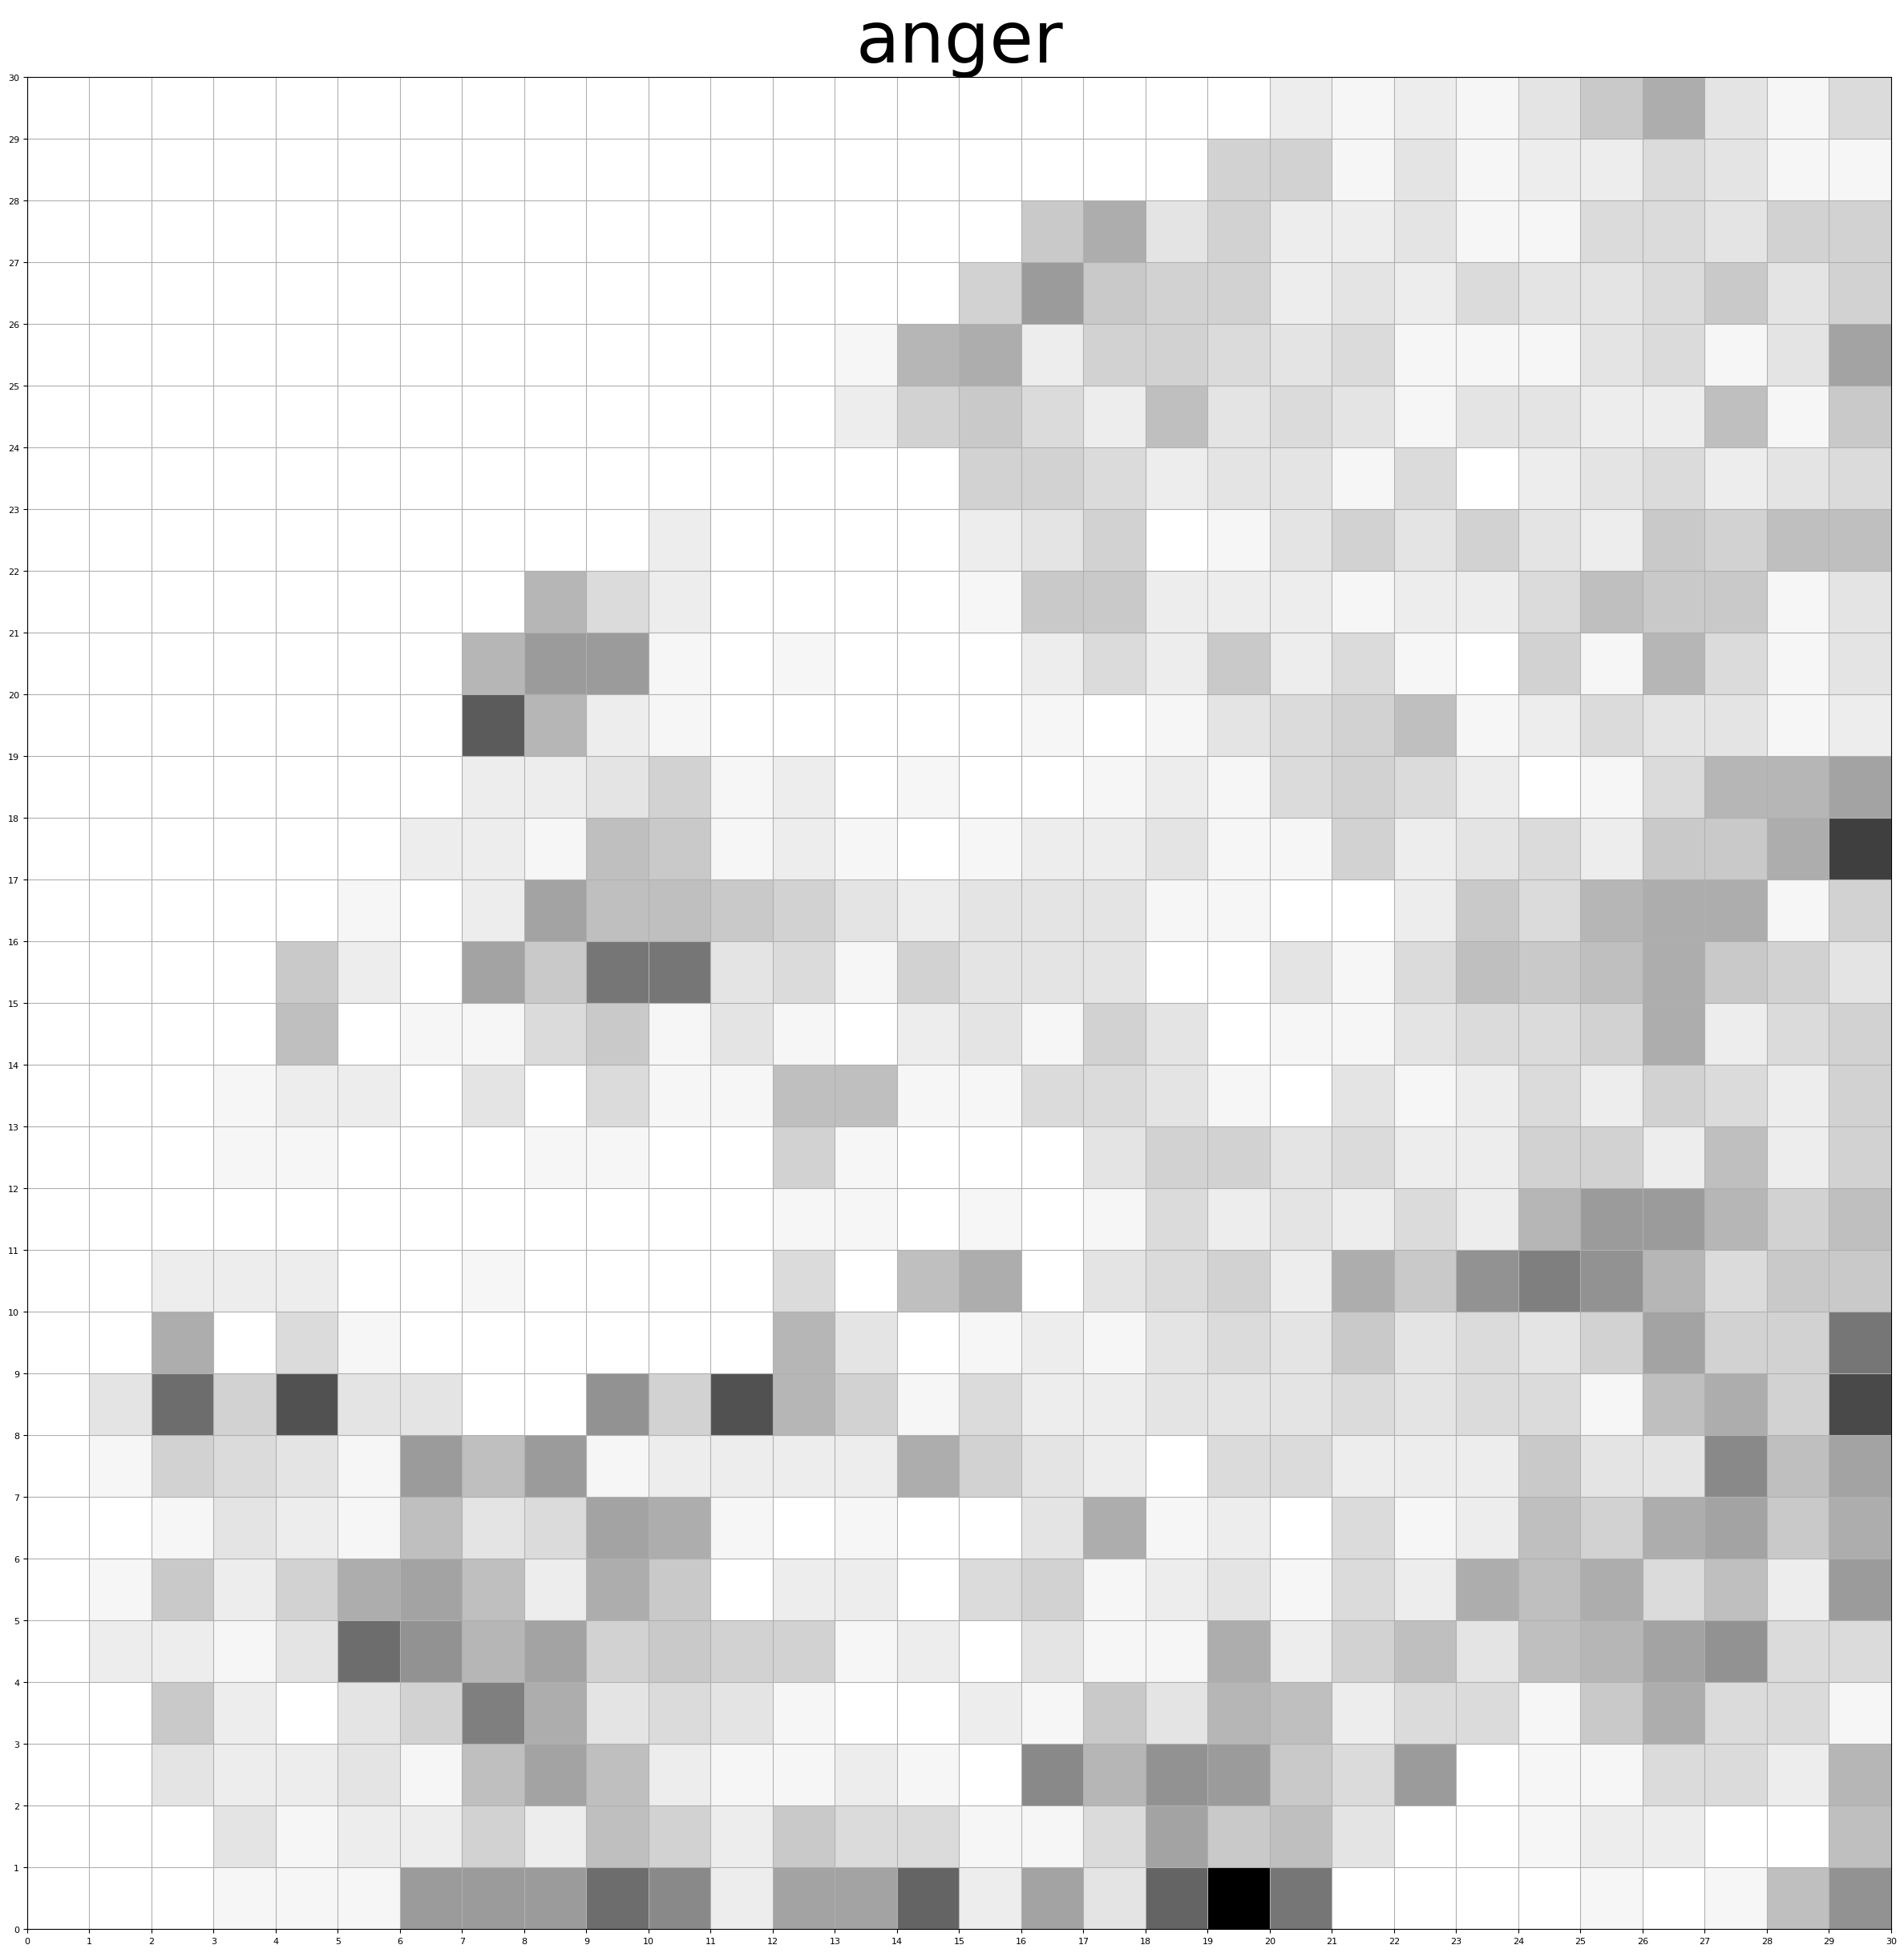

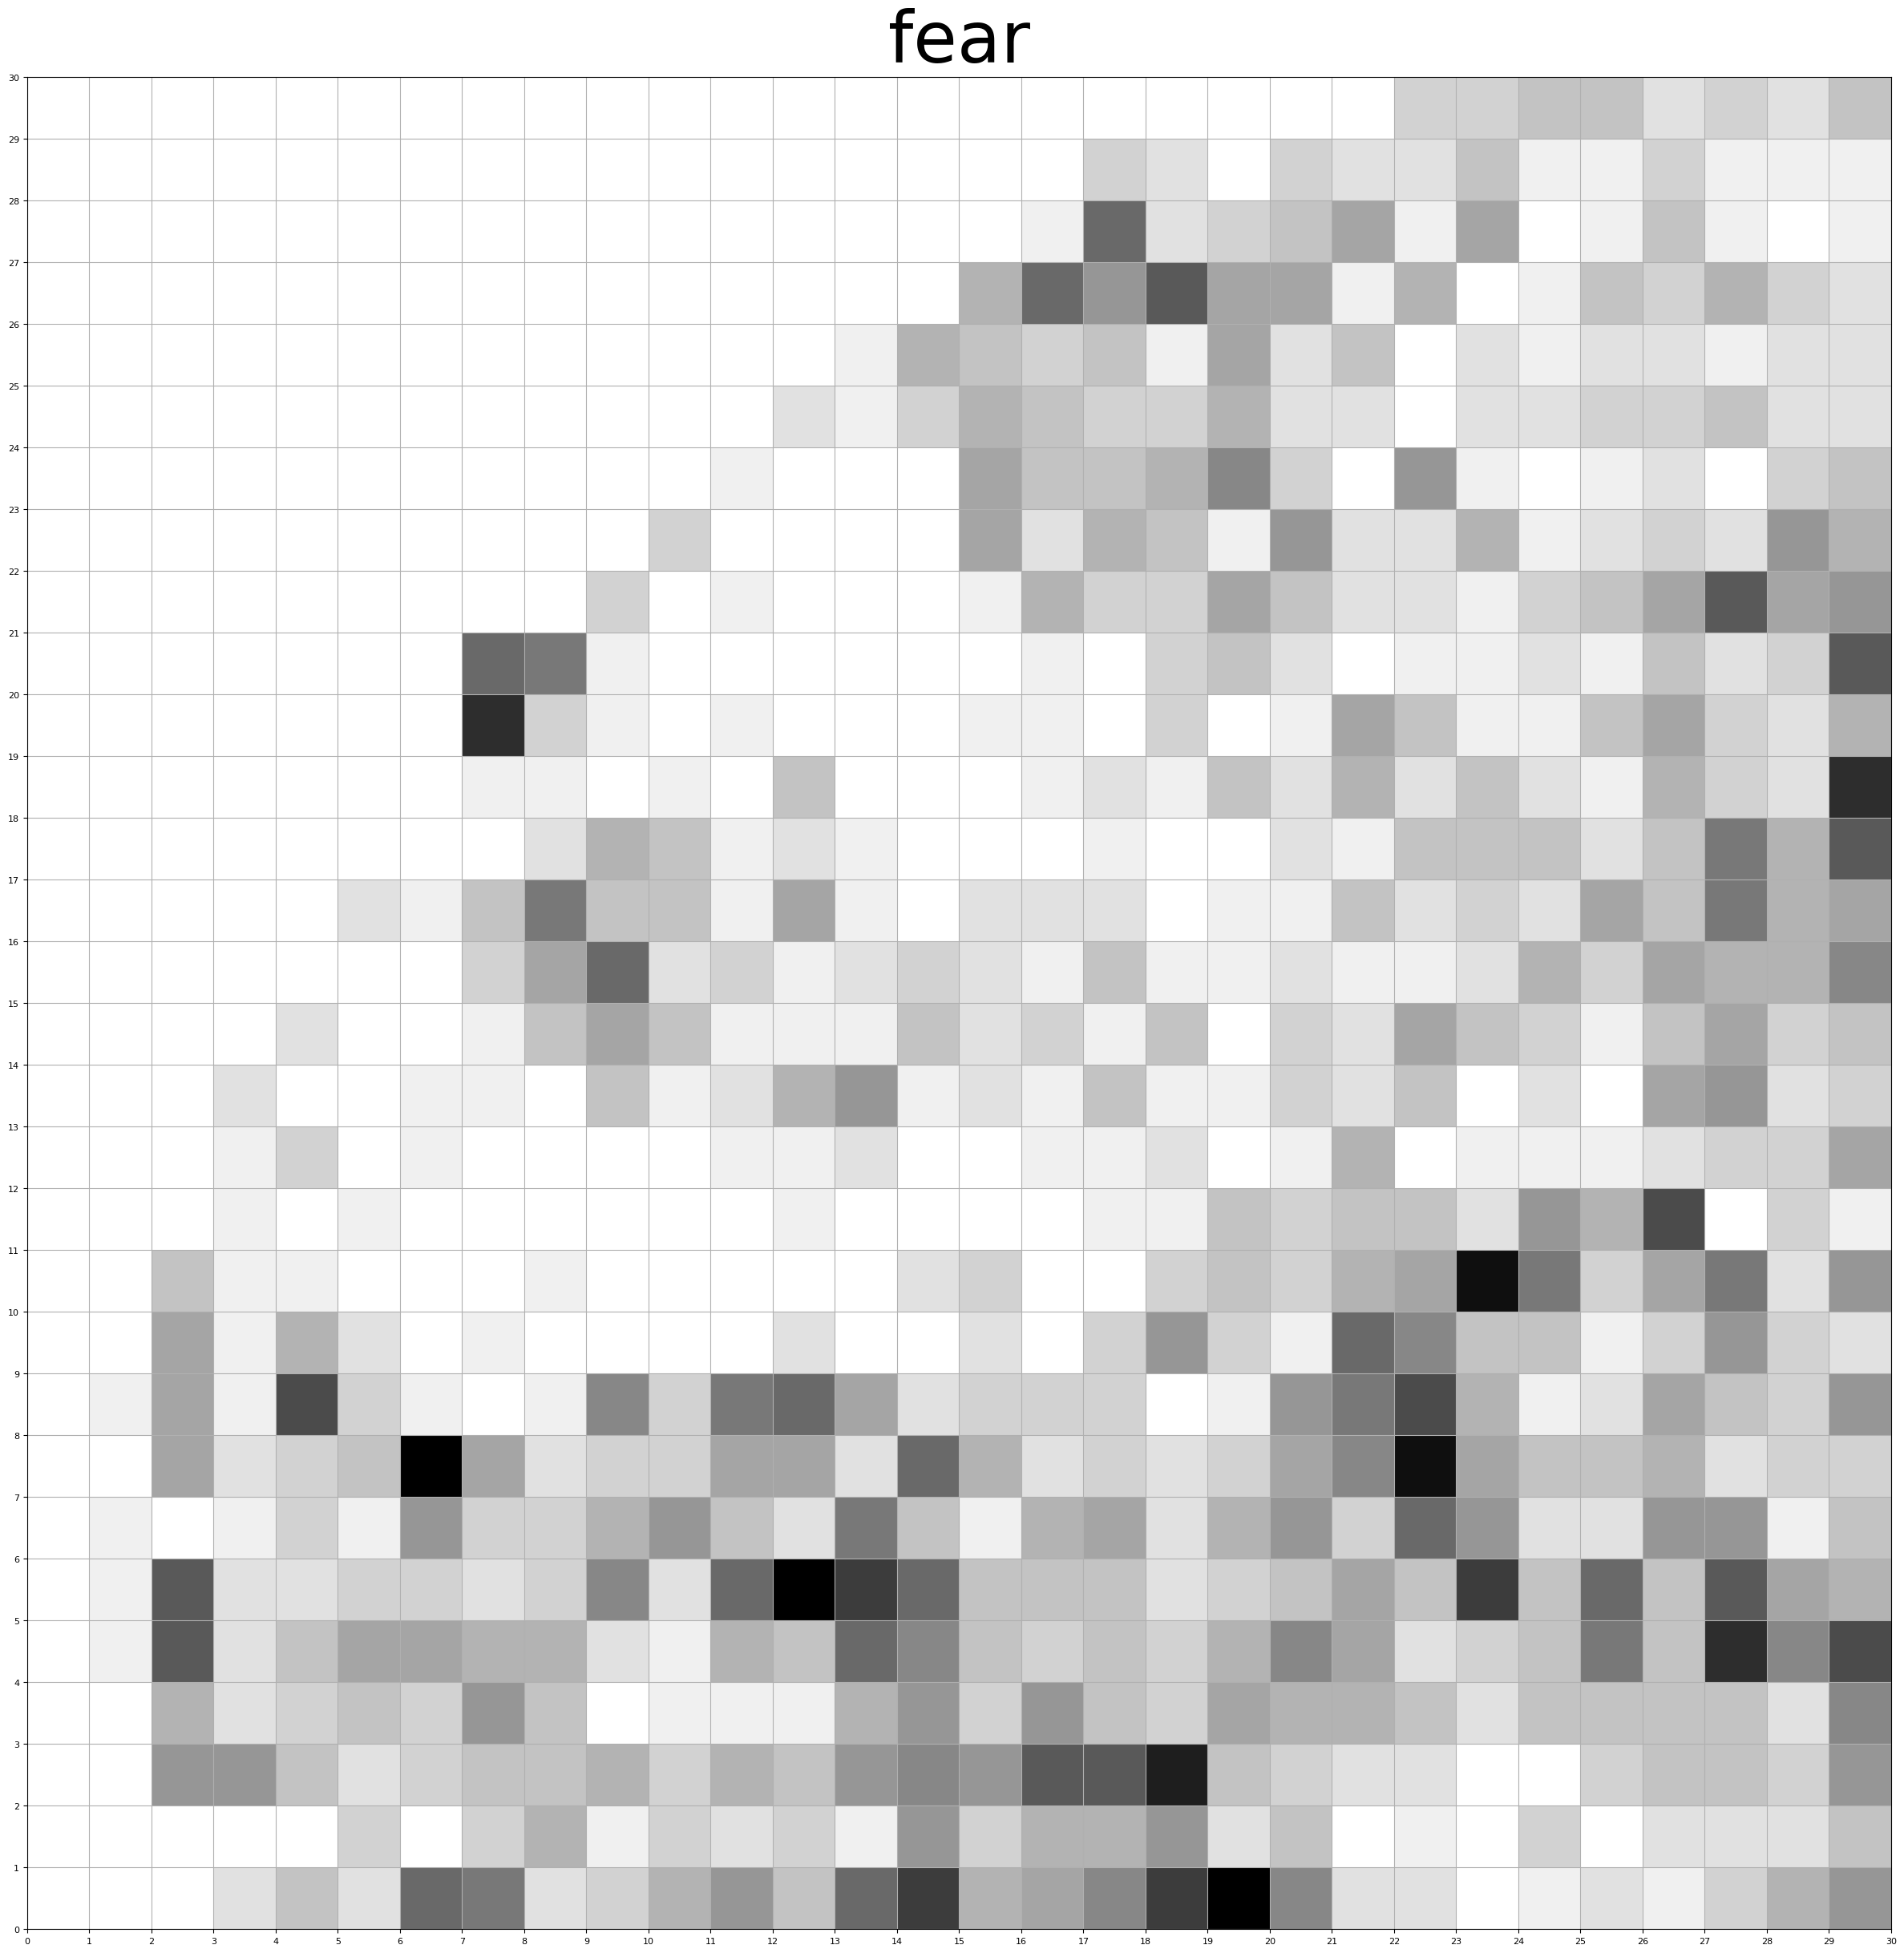

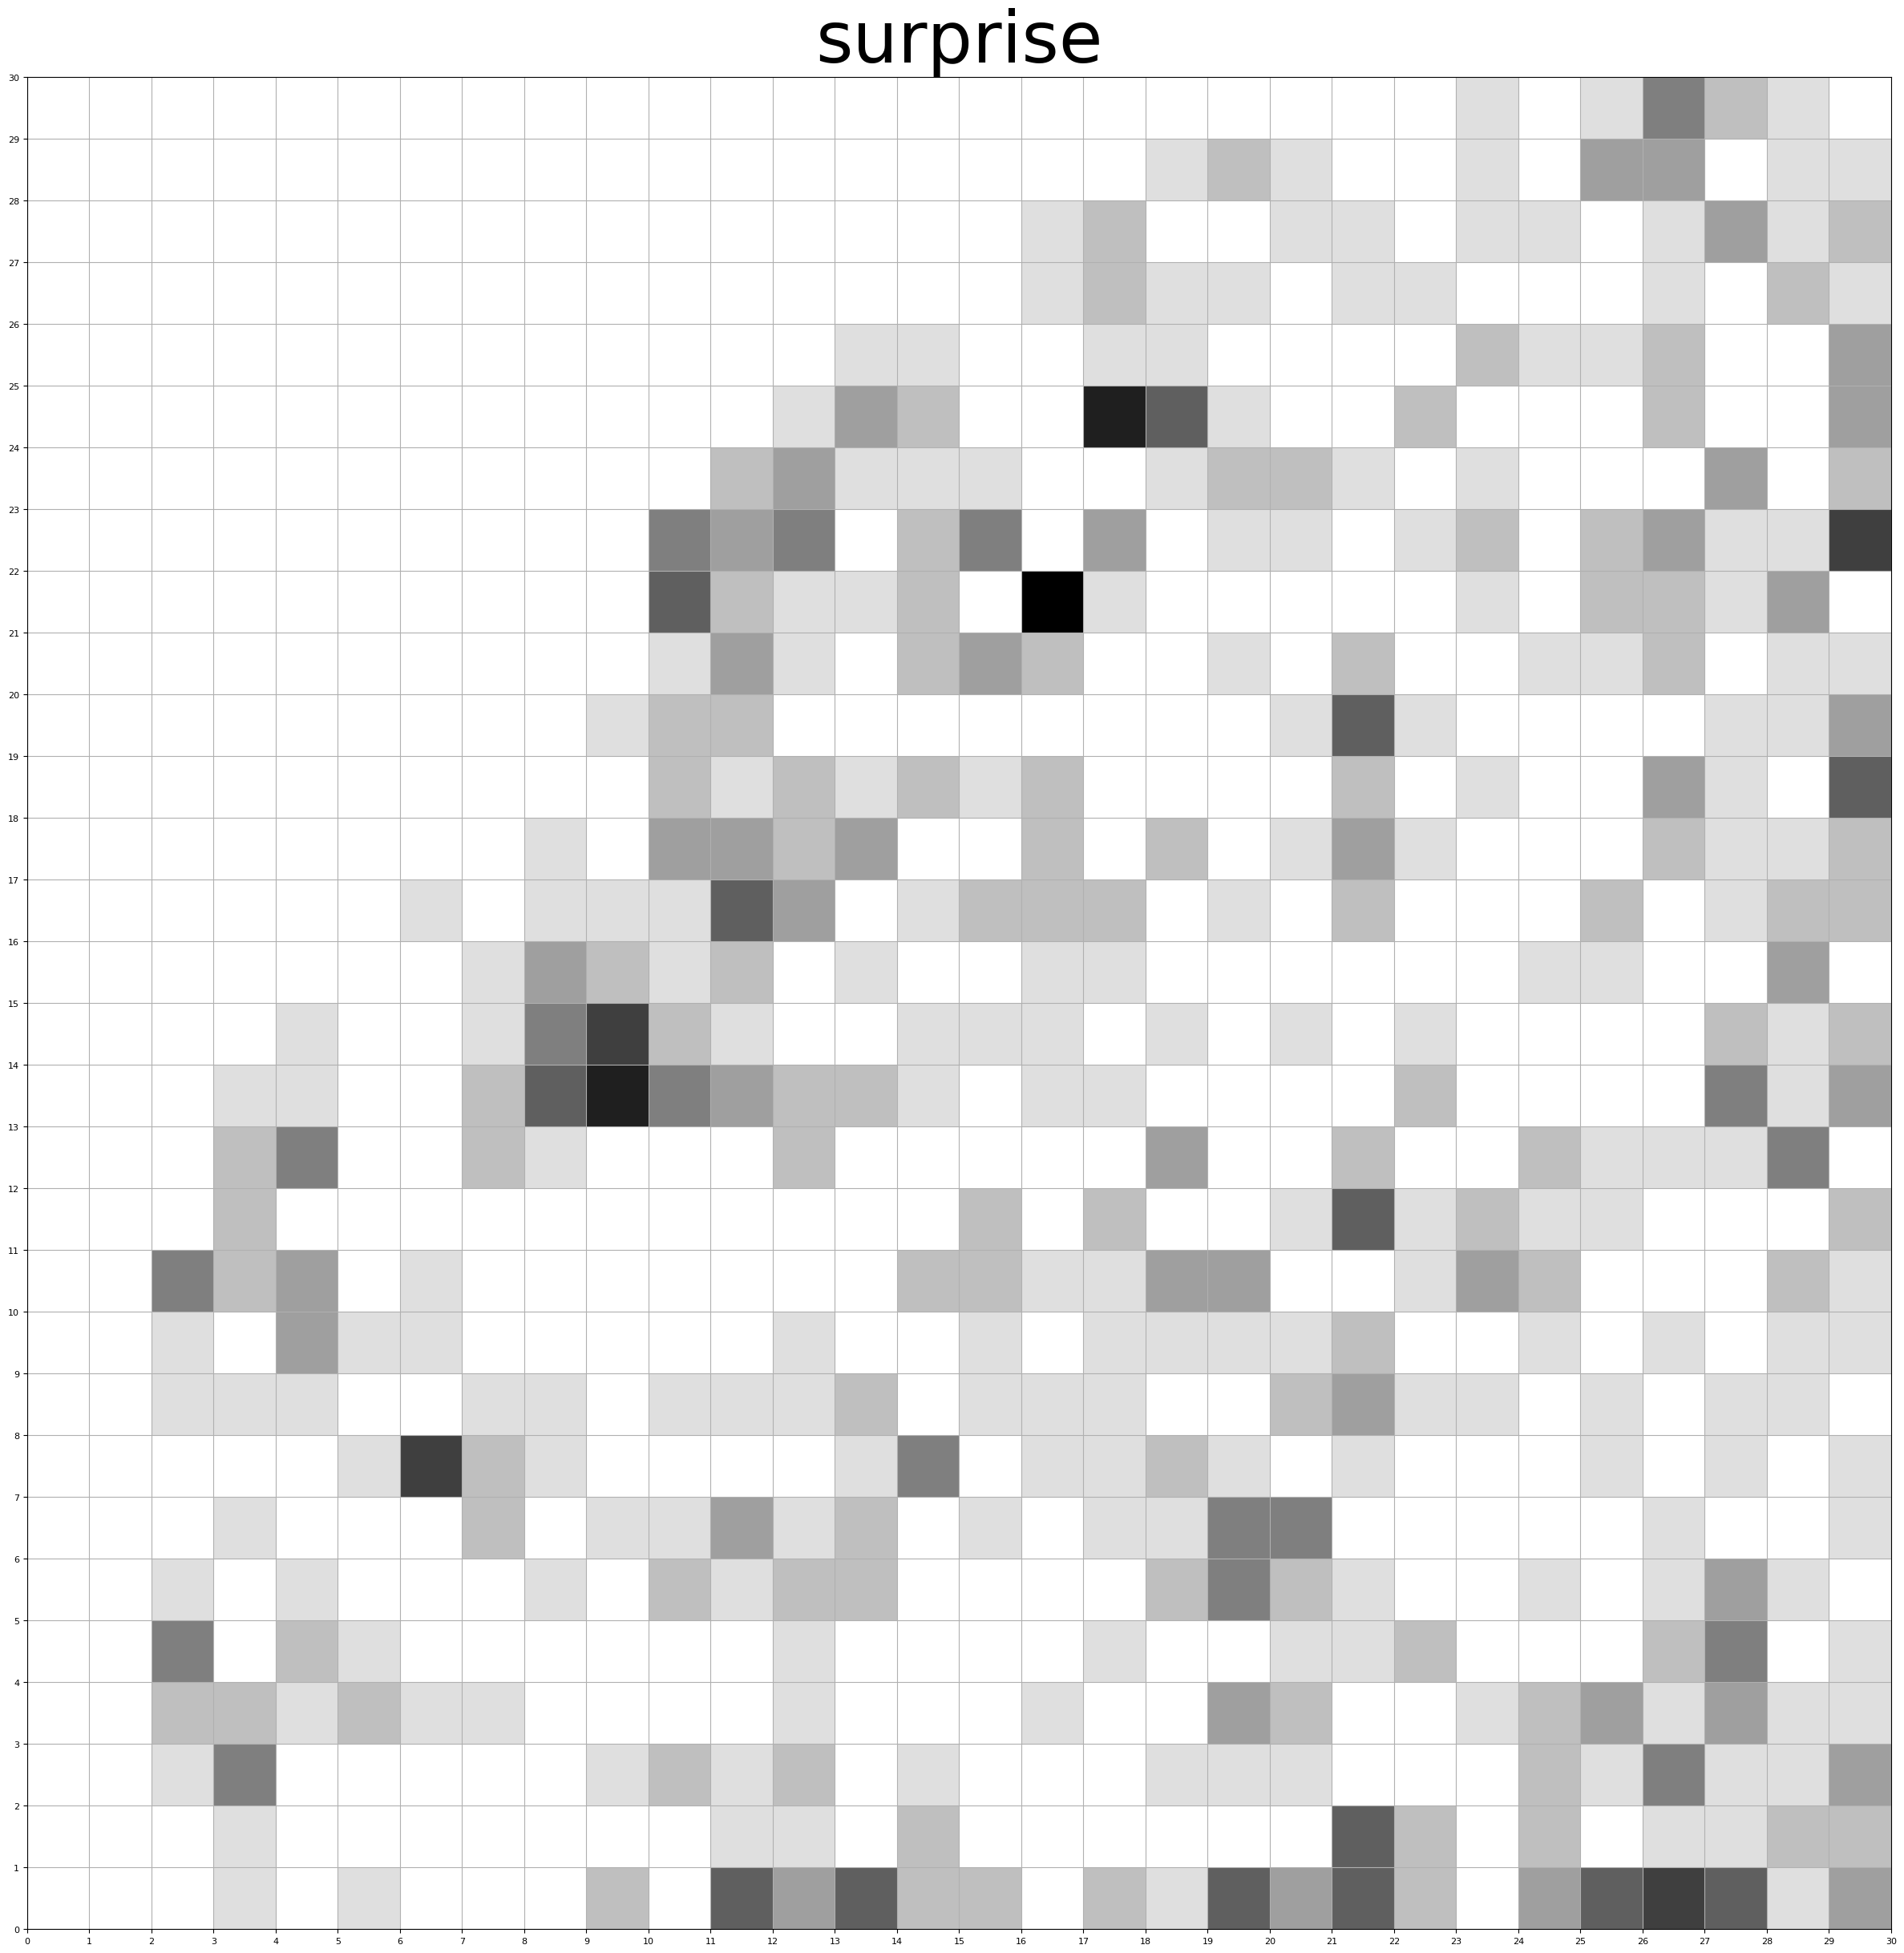

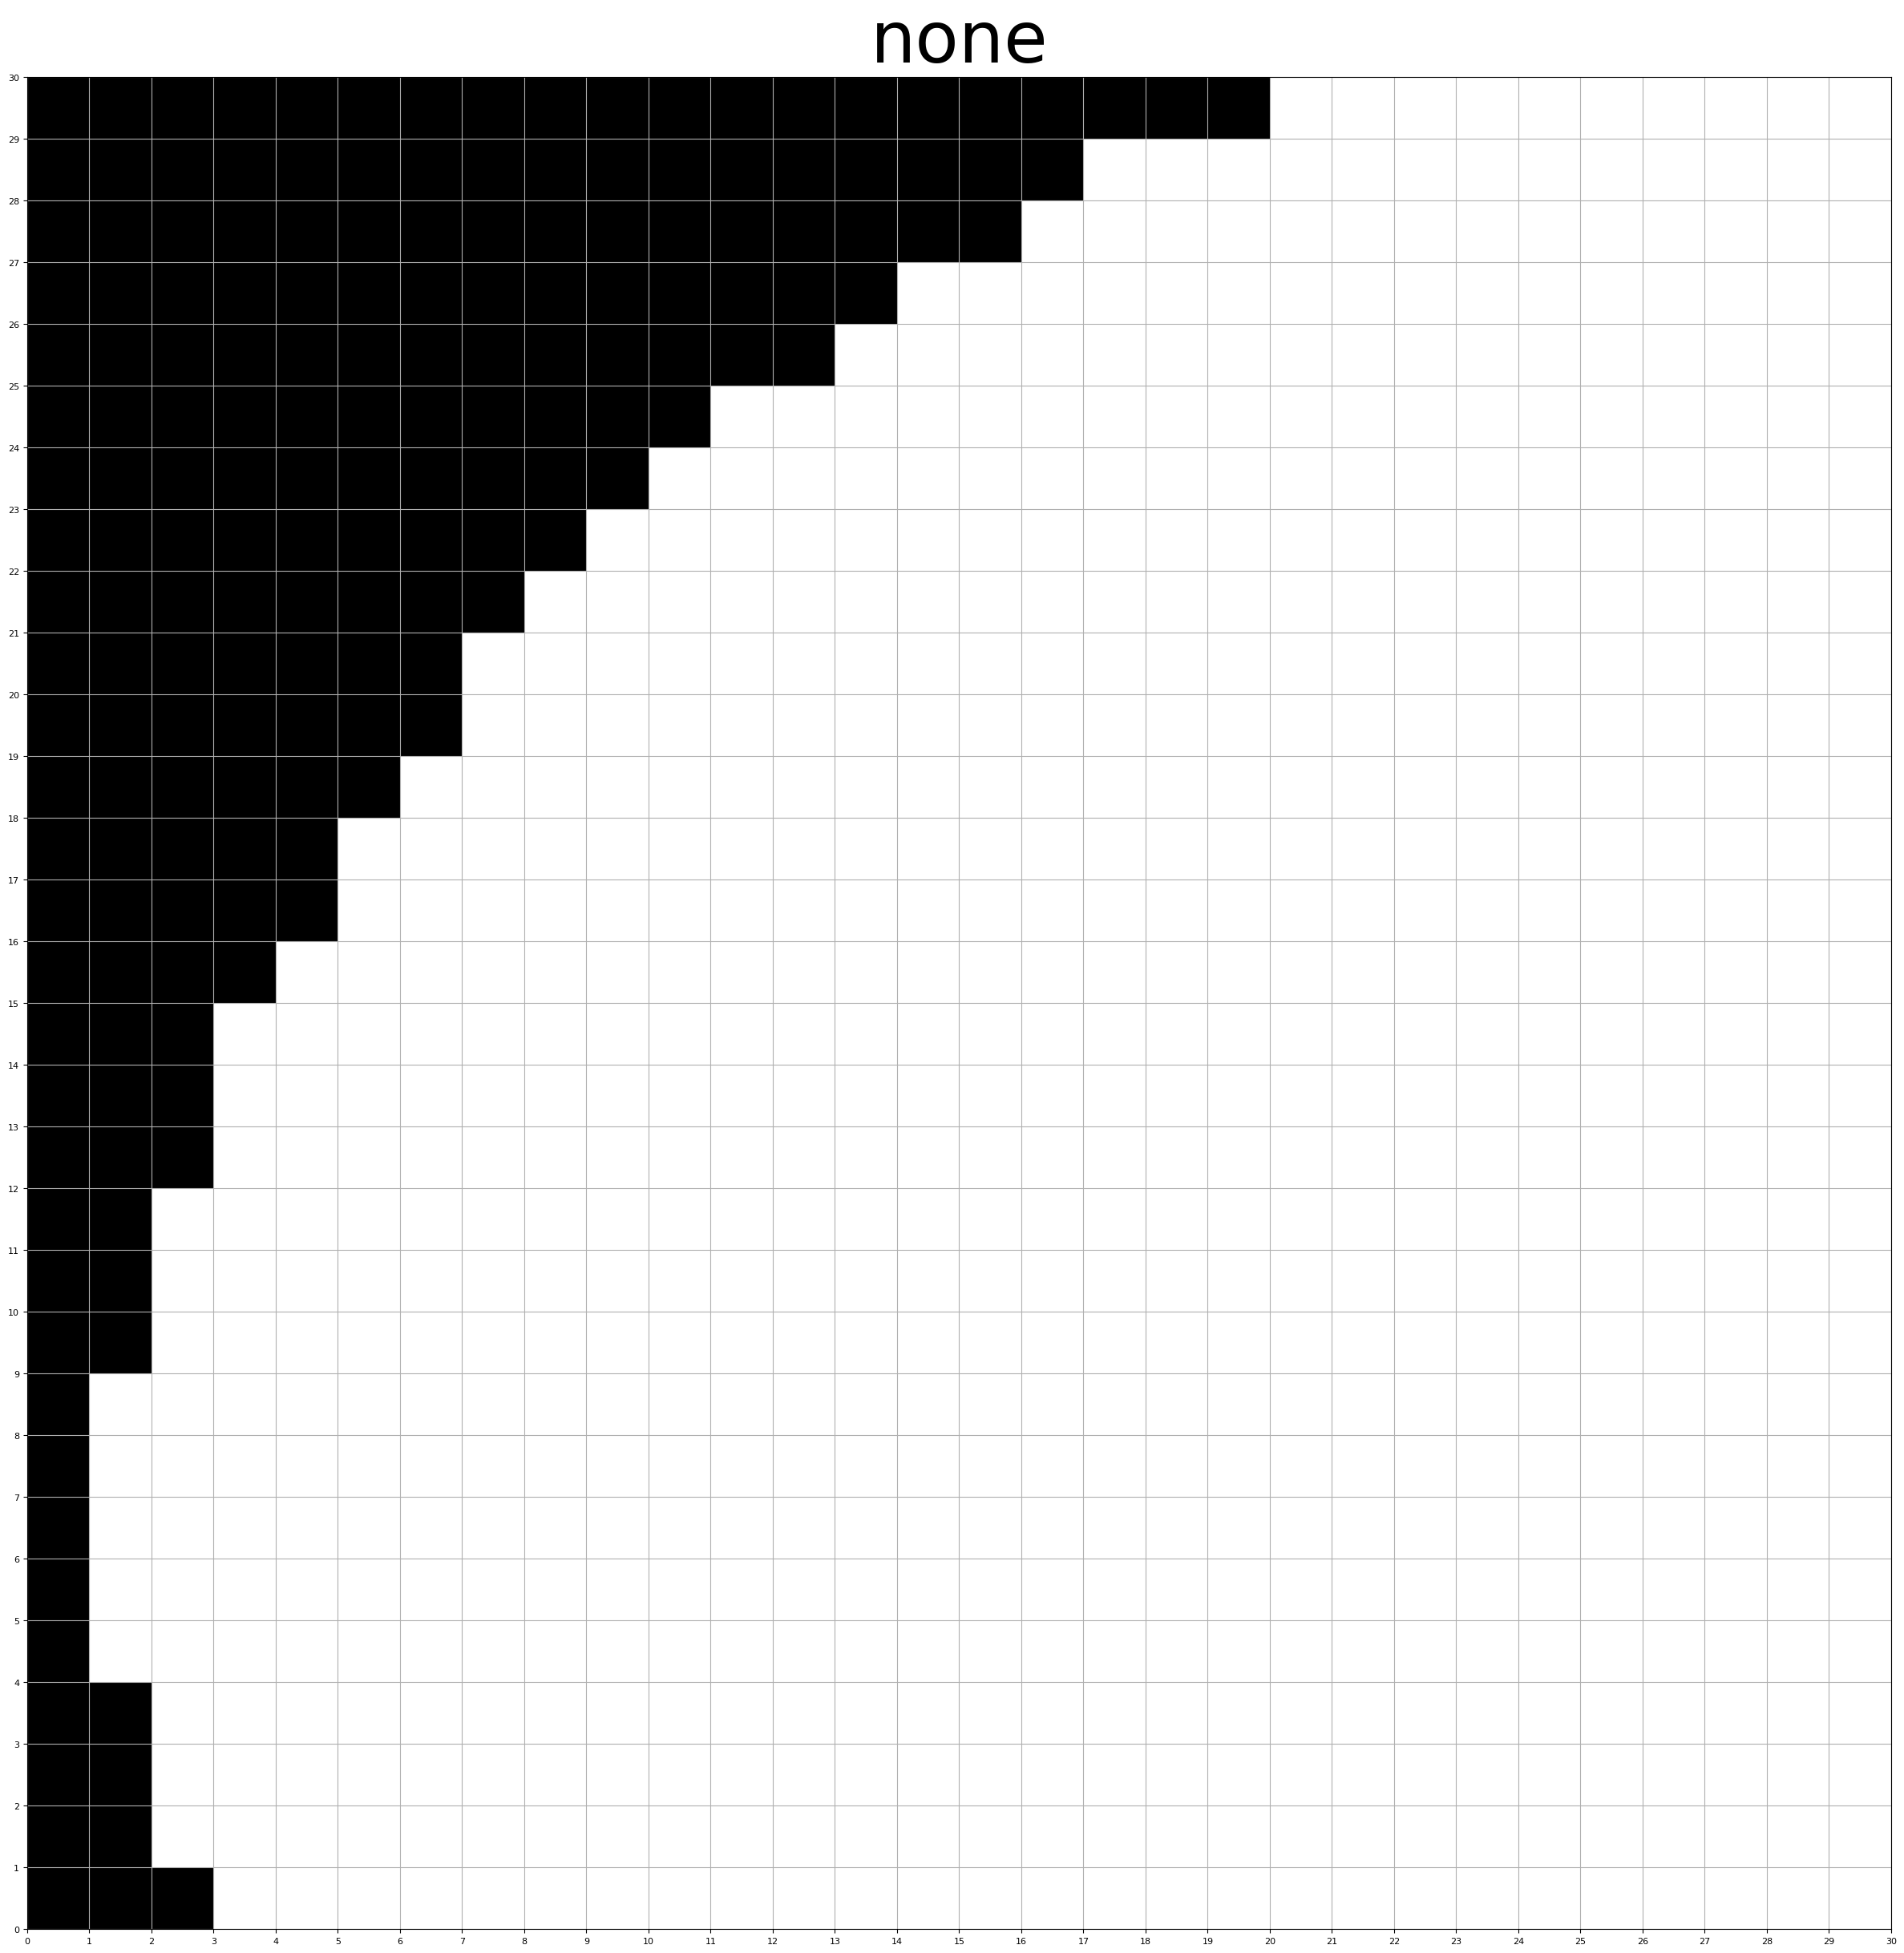

In [149]:
for i in range(0, len(CLASSES)):
    plot_som_per_class(i)